In [48]:
import numpy as np
import pandas as pd


df2 = pd.read_csv('BostonHousing.csv')
print(df2.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   crim     506 non-null    float64
 1   zn       506 non-null    float64
 2   indus    506 non-null    float64
 3   chas     506 non-null    int64  
 4   nox      506 non-null    float64
 5   rm       501 non-null    float64
 6   age      506 non-null    float64
 7   dis      506 non-null    float64
 8   rad      506 non-null    int64  
 9   tax      506 non-null    int64  
 10  ptratio  506 non-null    float64
 11  b        506 non-null    float64
 12  lstat    506 non-null    float64
 13  medv     506 non-null    float64
dtypes: float64(11), int64(3)
memory usage: 55.5 KB
None


In [49]:
df2.isna().sum()

crim       0
zn         0
indus      0
chas       0
nox        0
rm         5
age        0
dis        0
rad        0
tax        0
ptratio    0
b          0
lstat      0
medv       0
dtype: int64

In [50]:
df2.dropna(inplace = True)

In [51]:
df2.isna().sum()

crim       0
zn         0
indus      0
chas       0
nox        0
rm         0
age        0
dis        0
rad        0
tax        0
ptratio    0
b          0
lstat      0
medv       0
dtype: int64

In [52]:
df2.shape

(501, 14)

In [53]:
X = df2.drop('medv', axis = 1)
y = df2['medv']

In [54]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

from sklearn.metrics import r2_score

In [55]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2, random_state = 42)

In [56]:
from sklearn.preprocessing import StandardScaler

class MyLinearRegression:
    def __init__(self, learning_rate=0.01, iterations=1000):
        self.learning_rate = learning_rate
        self.iterations = iterations
        self.theta = None
        self.scaler = StandardScaler() 
        
    def fit(self, X, y):
        X_scaled = self.scaler.fit_transform(X)  
        m, n = X_scaled.shape
        self.theta = np.zeros(n + 1)  
        X_b = np.hstack([np.ones((m, 1)), X_scaled]) 
 
        for iteration in range(self.iterations):
            predictions = X_b.dot(self.theta)
            errors = predictions - y
            gradients = 2/m * X_b.T.dot(errors)
            self.theta -= self.learning_rate * gradients
            if iteration % 100 == 0: 
                print(f"Iteration {iteration}: Gradient norm = {np.linalg.norm(gradients)}")

    def predict(self, X_new):
        X_new_scaled = self.scaler.transform(X_new) 
        X_new_b = np.hstack([np.ones((X_new_scaled.shape[0], 1)), X_new_scaled])
        return X_new_b.dot(self.theta)

In [57]:
learning_rate=0.01
iterations=1000

lr = MyLinearRegression(learning_rate, iterations)
lr.fit(X_train, y_train)

Iteration 0: Gradient norm = 54.47902639689538
Iteration 100: Gradient norm = 6.275780094176261
Iteration 200: Gradient norm = 1.0593754085704665
Iteration 300: Gradient norm = 0.48865438495952507
Iteration 400: Gradient norm = 0.3593279535034909
Iteration 500: Gradient norm = 0.2818196707990781
Iteration 600: Gradient norm = 0.22856172148562728
Iteration 700: Gradient norm = 0.19037872028234987
Iteration 800: Gradient norm = 0.16188205638672143
Iteration 900: Gradient norm = 0.13974971181618065


In [58]:
y_pred1 = lr.predict(X_test)

In [59]:
r2 = r2_score(y_test,y_pred1)

In [60]:
df3 = pd.DataFrame(columns=['Method', 'R2 Score','Description'])

In [61]:
new_index = len(df3)  
df3.loc[new_index] = ['Linear Regression', r2,"learning_rate=0.01 and iterations=1000"]

In [62]:
print(df3)

              Method  R2 Score                             Description
0  Linear Regression  0.717608  learning_rate=0.01 and iterations=1000


In [63]:
class MyKNeighborsRegressor:
    def __init__(self, k=3):
        self.k = k
        self.X_train = None
        self.y_train = None

    def fit(self, X, y):
        self.X_train = X
        self.y_train = y

    def predict(self, X_new):
        predictions = []
        for index, x in X_new.iterrows():
            distances = self.X_train.apply(lambda row: np.linalg.norm(row - x), axis=1)
            k_indices = distances.nsmallest(self.k).index
            k_nearest_labels = self.y_train.loc[k_indices]
            predictions.append(k_nearest_labels.mean())
        return pd.Series(predictions)


In [64]:
knn = MyKNeighborsRegressor(k=3)
knn.fit(X_train, y_train)
y_pred2 = knn.predict(X_test)

In [65]:
r2 = r2_score(y_test,y_pred2)

In [66]:
new_index = len(df3)  
df3.loc[new_index] = ['KNeighborsRegressor', r2,"k=3"]


In [67]:
print(df3)

                Method  R2 Score                             Description
0    Linear Regression  0.717608  learning_rate=0.01 and iterations=1000
1  KNeighborsRegressor  0.461170                                     k=3


In [68]:
class MyDecisionTreeRegressor:
    def __init__(self, max_depth=3, random_state=None):
        self.max_depth = max_depth
        self.random_state = random_state
        self.tree = {}

    def fit(self, X, y):
        data = X.copy()
        data['target'] = y
        self.tree = self._build_tree(data, depth=0)

    def _build_tree(self, data, depth):
        if depth >= self.max_depth or len(data) <= 2:
            return {'value': data['target'].mean()}

        best_feature, best_value = self._best_split(data)

        left_split = data[data[best_feature] <= best_value]
        right_split = data[data[best_feature] > best_value]

        left_tree = self._build_tree(left_split, depth + 1)
        right_tree = self._build_tree(right_split, depth + 1)

        return {'feature': best_feature, 'value': best_value, 'left': left_tree, 'right': right_tree}

    def _best_split(self, data):
        best_variance = float('inf')
        best_feature = None
        best_value = None

        for feature in data.columns[:-1]: 
            value = data[feature].median()
            left_split = data[data[feature] <= value]
            right_split = data[data[feature] > value]
            variance = self._calculate_variance_reduction(data['target'], left_split['target'], right_split['target'])

            if variance < best_variance:
                best_variance = variance
                best_feature = feature
                best_value = value

        return best_feature, best_value

    def _calculate_variance_reduction(self, overall_target, left_target, right_target):
        weight_left = len(left_target) / len(overall_target)
        weight_right = len(right_target) / len(overall_target)
        variance_reduction = overall_target.var() - (weight_left * left_target.var() + weight_right * right_target.var())
        return variance_reduction

    def predict(self, X):
        predictions = X.apply(self._predict_single, axis=1)
        return predictions

    def _predict_single(self, x):
        node = self.tree
        while 'feature' in node:
            if x[node['feature']] <= node['value']:
                node = node['left']
            else:
                node = node['right']
        return node['value']

In [69]:
tree = MyDecisionTreeRegressor(max_depth=3, random_state=42)
tree.fit(X_train, y_train)

In [70]:
y_pred3 = tree.predict(X_test)

In [71]:
r2 = r2_score(y_test, y_pred3)

In [72]:
new_index = len(df3)  
df3.loc[new_index] = ['DecisionTreeRegressor', r2,"max_depth=3, random_state=42"]

In [73]:
print(df3)

                  Method  R2 Score                             Description
0      Linear Regression  0.717608  learning_rate=0.01 and iterations=1000
1    KNeighborsRegressor  0.461170                                     k=3
2  DecisionTreeRegressor  0.106680            max_depth=3, random_state=42


In [74]:
from sklearn.utils import resample

class MyDecisionTreeRegressor:
    def __init__(self, max_depth=3):
        self.max_depth = max_depth
        self.tree = {}

    def fit(self, X, y):
       
        data = pd.concat([X, y.rename('target')], axis=1)  
        self.tree = self._build_tree(data, 0)

    def _build_tree(self, data, depth):
        if depth >= self.max_depth or data.shape[0] <= 1:
            return {'value': data['target'].mean()}
        else:
            best_feature, best_threshold = self._find_best_split(data)
            left = data[data[best_feature] <= best_threshold]
            right = data[data[best_feature] > best_threshold]
            return {
                'feature': best_feature,
                'threshold': best_threshold,
                'left': self._build_tree(left, depth + 1),
                'right': self._build_tree(right, depth + 1)
            }

    def _find_best_split(self, data):
        best_feature = np.random.choice(data.columns[:-1])
        best_threshold = data[best_feature].median()
        return best_feature, best_threshold

    def predict(self, X):
        results = [self._predict_row(row, self.tree) for _, row in X.iterrows()]
        return np.array(results)

    def _predict_row(self, row, node):
        if 'value' in node:
            return node['value']
        if row[node['feature']] <= node['threshold']:
            return self._predict_row(row, node['left'])
        else:
            return self._predict_row(row, node['right'])

class MyRandomForestRegressor:
    def __init__(self, n_estimators=10, max_depth=3):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.trees = []

    def fit(self, X, y):
        for _ in range(self.n_estimators):
            sample_X, sample_y = resample(X, y)
            tree = MyDecisionTreeRegressor(max_depth=self.max_depth)
            tree.fit(sample_X, sample_y)
            self.trees.append(tree)

    def predict(self, X):
        tree_preds = [tree.predict(X) for tree in self.trees]
        return np.mean(tree_preds, axis=0)


In [75]:


rf_regressor = MyRandomForestRegressor(n_estimators=10, max_depth=3)
rf_regressor.fit(X_train, y_train)

In [76]:
y_pred4 = rf_regressor.predict(X_test)

In [77]:
nan_in_pred = np.isnan(y_pred4).any()
nan_in_test = np.isnan(y_test).any()

print("NaNs in predictions:", nan_in_pred)
print("NaNs in test labels:", nan_in_test)


if nan_in_pred or nan_in_test:
    valid_indices = ~np.isnan(y_pred4) & ~np.isnan(y_test)
    y_pred_clean = y_pred4[valid_indices]
    y_test_clean = y_test[valid_indices]
else:
    y_pred_clean = y_pred4
    y_test_clean = y_test

r2 = r2_score(y_test_clean, y_pred_clean)
print("R^2 score:", r2)


NaNs in predictions: False
NaNs in test labels: False
R^2 score: 0.45084993531849127


In [78]:
new_index = len(df3)  
df3.loc[new_index] = ['RandomForestRegressor', r2,"n_estimators=10, max_depth=3"]

In [79]:
print(df3)

                  Method  R2 Score                             Description
0      Linear Regression  0.717608  learning_rate=0.01 and iterations=1000
1    KNeighborsRegressor  0.461170                                     k=3
2  DecisionTreeRegressor  0.106680            max_depth=3, random_state=42
3  RandomForestRegressor  0.450850            n_estimators=10, max_depth=3


In [80]:
class MyLinearSVMRegressor:
    def __init__(self, learning_rate=0.01, epochs=1000, C=1.0):
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.C = C 
        self.weights = None
        self.bias = 0

    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.weights = np.zeros(n_features)

        X_np = X.to_numpy()
        y_np = y.to_numpy()

        for _ in range(self.epochs):
            for idx, x_i in enumerate(X_np):
                condition = y_np[idx] - np.dot(x_i, self.weights) - self.bias
                if condition > 1:
                    self.weights -= self.learning_rate * (2 * self.C * self.weights)
                    self.bias -= self.learning_rate * (2 * self.C * self.bias)
                else:
                    self.weights -= self.learning_rate * (2 * self.C * self.weights - np.dot(x_i, y_np[idx]))
                    self.bias -= self.learning_rate * (2 * self.C * self.bias - y_np[idx])

    def predict(self, X):
      
        return np.dot(X.to_numpy(), self.weights) + self.bias

In [81]:
svm_regressor = MyLinearSVMRegressor(learning_rate=0.01, epochs=1000, C=0.1)
svm_regressor.fit(X_train, y_train)
y_pred5 = svm_regressor.predict(X_test)

In [82]:
r2 = r2_score(y_test,y_pred5)

In [83]:
new_index = len(df3)  
df3.loc[new_index] = ['SVR', r2,"learning_rate=0.01, epochs=1000, C=0.1"]

In [84]:
print(df3)

                  Method  R2 Score                             Description
0      Linear Regression  0.717608  learning_rate=0.01 and iterations=1000
1    KNeighborsRegressor  0.461170                                     k=3
2  DecisionTreeRegressor  0.106680            max_depth=3, random_state=42
3  RandomForestRegressor  0.450850            n_estimators=10, max_depth=3
4                    SVR -6.085796  learning_rate=0.01, epochs=1000, C=0.1


In [85]:
class MyNeuralNetworkRegressor:
    def __init__(self, input_dim, hidden_dim, output_dim=1, learning_rate=0.01, epochs=1000):
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.learning_rate = learning_rate
        self.epochs = epochs

        np.random.seed(42)
        self.weights_input_to_hidden = np.random.randn(self.input_dim, self.hidden_dim) * 0.01
        self.weights_hidden_to_output = np.random.randn(self.hidden_dim, self.output_dim) * 0.01
        self.bias_hidden = np.zeros((1, self.hidden_dim))
        self.bias_output = np.zeros((1, self.output_dim))

    def fit(self, X, y):
        for epoch in range(self.epochs):

            hidden_layer_input = np.dot(X, self.weights_input_to_hidden) + self.bias_hidden
            hidden_layer_output = np.tanh(hidden_layer_input)
            output_layer_input = np.dot(hidden_layer_output, self.weights_hidden_to_output) + self.bias_output
            y_pred = output_layer_input
            
      
            loss = np.mean((y_pred - y) ** 2)
            if epoch % 100 == 0:
                print(f"Epoch {epoch}, Loss: {loss}")
            
         
            d_loss_y_pred = 2 * (y_pred - y) / y.shape[0]
            d_y_pred_output_w = hidden_layer_output
            d_y_pred_output_b = 1
            
        
            d_y_pred_hidden_output = self.weights_hidden_to_output
            d_hidden_output_hidden_input = 1 - np.tanh(hidden_layer_input) ** 2
       
          
            self.weights_hidden_to_output -= self.learning_rate * np.dot(d_y_pred_output_w.T, d_loss_y_pred)
            self.bias_output -= self.learning_rate * np.sum(d_loss_y_pred, axis=0, keepdims=True)
            
         
            d_loss_hidden_input = np.dot(d_loss_y_pred, d_y_pred_hidden_output.T) * d_hidden_output_hidden_input
            self.weights_input_to_hidden -= self.learning_rate * np.dot(X.T, d_loss_hidden_input)
            self.bias_hidden -= self.learning_rate * np.sum(d_loss_hidden_input, axis=0, keepdims=True)

    def predict(self, X):
  
        hidden_layer_input = np.dot(X, self.weights_input_to_hidden) + self.bias_hidden
        hidden_layer_output = np.tanh(hidden_layer_input)
        output_layer_input = np.dot(hidden_layer_output, self.weights_hidden_to_output) + self.bias_output
        y_pred = output_layer_input
        return y_pred


X_train_np = X_train.to_numpy()  
y_train_np = y_train.to_numpy().reshape(-1, 1)  




In [86]:
nn = MyNeuralNetworkRegressor(input_dim=X_train.shape[1], hidden_dim=5, learning_rate=0.01, epochs=1000)
nn.fit(X_train_np, y_train_np)
y_pred_nn = nn.predict(X_test.to_numpy())

Epoch 0, Loss: 610.9207543042243
Epoch 100, Loss: 87.30863775437852
Epoch 200, Loss: 87.30863775
Epoch 300, Loss: 87.30863775
Epoch 400, Loss: 87.30863775
Epoch 500, Loss: 87.30863775
Epoch 600, Loss: 87.30863775
Epoch 700, Loss: 87.30863775
Epoch 800, Loss: 87.30863775
Epoch 900, Loss: 87.30863775


In [87]:
r2 = r2_score(y_test,y_pred_nn)

In [88]:
new_index = len(df3)  
df3.loc[new_index] = ['Nueral Network', r2,"hidden_dim=5, learning_rate=0.01, epochs=1000"]

In [89]:
print(df3)

                  Method  R2 Score  \
0      Linear Regression  0.717608   
1    KNeighborsRegressor  0.461170   
2  DecisionTreeRegressor  0.106680   
3  RandomForestRegressor  0.450850   
4                    SVR -6.085796   
5         Nueral Network -0.038999   

                                     Description  
0         learning_rate=0.01 and iterations=1000  
1                                            k=3  
2                   max_depth=3, random_state=42  
3                   n_estimators=10, max_depth=3  
4         learning_rate=0.01, epochs=1000, C=0.1  
5  hidden_dim=5, learning_rate=0.01, epochs=1000  


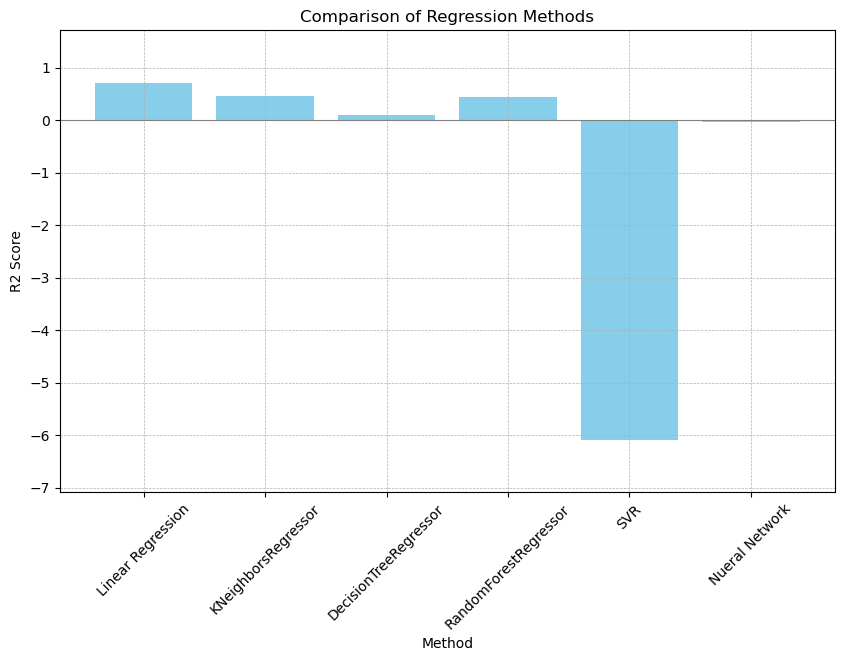

In [90]:
import matplotlib.pyplot as plt

methods = df3['Method'].tolist() 
r2_scores = df3['R2 Score'].tolist()

plt.figure(figsize=(10, 6))
plt.bar(methods, r2_scores, color='skyblue')
plt.xlabel('Method')
plt.ylabel('R2 Score')
plt.title('Comparison of Regression Methods')
plt.xticks(rotation=45)
plt.ylim(min(r2_scores) - 1, max(r2_scores) + 1)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.axhline(0, color='gray', linewidth=0.8)
plt.show()

In [91]:
df1 = pd.read_csv('miami-housing.csv')
print(df1.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13932 entries, 0 to 13931
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   LATITUDE           13932 non-null  float64
 1   LONGITUDE          13932 non-null  float64
 2   PARCELNO           13932 non-null  int64  
 3   SALE_PRC           13932 non-null  float64
 4   LND_SQFOOT         13932 non-null  int64  
 5   TOT_LVG_AREA       13932 non-null  int64  
 6   SPEC_FEAT_VAL      13932 non-null  int64  
 7   RAIL_DIST          13932 non-null  float64
 8   OCEAN_DIST         13932 non-null  float64
 9   WATER_DIST         13932 non-null  float64
 10  CNTR_DIST          13932 non-null  float64
 11  SUBCNTR_DI         13932 non-null  float64
 12  HWY_DIST           13932 non-null  float64
 13  age                13932 non-null  int64  
 14  avno60plus         13932 non-null  int64  
 15  month_sold         13932 non-null  int64  
 16  structure_quality  139

In [92]:
df1.isna().sum()

LATITUDE             0
LONGITUDE            0
PARCELNO             0
SALE_PRC             0
LND_SQFOOT           0
TOT_LVG_AREA         0
SPEC_FEAT_VAL        0
RAIL_DIST            0
OCEAN_DIST           0
WATER_DIST           0
CNTR_DIST            0
SUBCNTR_DI           0
HWY_DIST             0
age                  0
avno60plus           0
month_sold           0
structure_quality    0
dtype: int64

In [93]:
X = df1.drop('SALE_PRC', axis = 1)
y = df1['SALE_PRC']

In [94]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2, random_state = 42)

In [95]:
from sklearn.preprocessing import StandardScaler

class MyLinearRegression:
    def __init__(self, learning_rate=0.01, iterations=1000):
        self.learning_rate = learning_rate
        self.iterations = iterations
        self.theta = None
        self.scaler = StandardScaler() 
        
    def fit(self, X, y):
        X_scaled = self.scaler.fit_transform(X)  
        m, n = X_scaled.shape
        self.theta = np.zeros(n + 1)  
        X_b = np.hstack([np.ones((m, 1)), X_scaled]) 
 
        for iteration in range(self.iterations):
            predictions = X_b.dot(self.theta)
            errors = predictions - y
            gradients = 2/m * X_b.T.dot(errors)
            self.theta -= self.learning_rate * gradients
            if iteration % 100 == 0: 
                print(f"Iteration {iteration}: Gradient norm = {np.linalg.norm(gradients)}")

    def predict(self, X_new):
        X_new_scaled = self.scaler.transform(X_new) 
        X_new_b = np.hstack([np.ones((X_new_scaled.shape[0], 1)), X_new_scaled])
        return X_new_b.dot(self.theta)

In [96]:
lr = MyLinearRegression()
lr.fit(X_train,y_train)

Iteration 0: Gradient norm = 1103043.4722429595
Iteration 100: Gradient norm = 115514.60242068382
Iteration 200: Gradient norm = 19160.49414918072
Iteration 300: Gradient norm = 5920.629511617298
Iteration 400: Gradient norm = 3553.8720271466987
Iteration 500: Gradient norm = 2961.468768670781
Iteration 600: Gradient norm = 2773.379215674339
Iteration 700: Gradient norm = 2685.0128577912847
Iteration 800: Gradient norm = 2623.260422288404
Iteration 900: Gradient norm = 2569.742187894924


In [97]:
y_pred1 = lr.predict(X_test)

In [98]:
r2 = r2_score(y_test,y_pred1)

In [99]:
df4 = pd.DataFrame(columns=['Method', 'R2 Score',"Description"])

In [100]:
new_index = len(df4)  
df4.loc[new_index] = ['Linear Regression', r2,"learning_rate=0.01, iterations=1000"]

In [101]:
print(df4)

              Method  R2 Score                          Description
0  Linear Regression  0.709414  learning_rate=0.01, iterations=1000


In [102]:


class MyKNeighborsRegressor:
    def __init__(self, k=3):
        self.k = k

    def fit(self, X, y):
        self.X_train = X
        self.y_train = y

    def predict(self, X_test):
        predictions = []
        for index, test_row in X_test.iterrows():
           
            distances = np.sqrt(((self.X_train - test_row) ** 2).sum(axis=1))

            k_indices = distances.nsmallest(self.k).index
    
            predictions.append(self.y_train.loc[k_indices].mean())
        return pd.Series(predictions, index=X_test.index)




In [103]:
knn = MyKNeighborsRegressor(k=3)

knn.fit(X_train, y_train)
y_pred2 = knn.predict(X_test)

In [104]:
r2 = r2_score(y_test,y_pred2)

In [105]:
new_index = len(df4)  
df4.loc[new_index] = ['KNeighborsRegressor', r2,"k = 3"]


In [106]:
print(df4)

                Method  R2 Score                          Description
0    Linear Regression  0.709414  learning_rate=0.01, iterations=1000
1  KNeighborsRegressor  0.749818                                k = 3


In [107]:
class MyDecisionTreeRegressor:
    def __init__(self, max_depth=3, random_state=None):
        self.max_depth = max_depth
        self.random_state = random_state
        self.tree = {}

    def fit(self, X, y):
        data = X.copy()
        data['target'] = y
        self.tree = self._build_tree(data, depth=0)

    def _build_tree(self, data, depth):
        if depth >= self.max_depth or len(data) <= 2:
            return {'value': data['target'].mean()}

        best_feature, best_value = self._best_split(data)

        left_split = data[data[best_feature] <= best_value]
        right_split = data[data[best_feature] > best_value]

        left_tree = self._build_tree(left_split, depth + 1)
        right_tree = self._build_tree(right_split, depth + 1)

        return {'feature': best_feature, 'value': best_value, 'left': left_tree, 'right': right_tree}

    def _best_split(self, data):
        best_variance = float('inf')
        best_feature = None
        best_value = None

        for feature in data.columns[:-1]: 
            value = data[feature].median()
            left_split = data[data[feature] <= value]
            right_split = data[data[feature] > value]
            variance = self._calculate_variance_reduction(data['target'], left_split['target'], right_split['target'])

            if variance < best_variance:
                best_variance = variance
                best_feature = feature
                best_value = value

        return best_feature, best_value

    def _calculate_variance_reduction(self, overall_target, left_target, right_target):
        weight_left = len(left_target) / len(overall_target)
        weight_right = len(right_target) / len(overall_target)
        variance_reduction = overall_target.var() - (weight_left * left_target.var() + weight_right * right_target.var())
        return variance_reduction

    def predict(self, X):
        predictions = X.apply(self._predict_single, axis=1)
        return predictions

    def _predict_single(self, x):
        node = self.tree
        while 'feature' in node:
            if x[node['feature']] <= node['value']:
                node = node['left']
            else:
                node = node['right']
        return node['value']

In [108]:
tree = MyDecisionTreeRegressor(max_depth=3, random_state=42)
tree.fit(X_train, y_train)

In [111]:
y_pred3 = tree.predict(X_test)

In [112]:
new_index = len(df4)  
df4.loc[new_index] = ['DecisionTreeRegressor', r2,"max_depth=3, random_state=42"]

In [113]:
print(df4)

                  Method  R2 Score                          Description
0      Linear Regression  0.709414  learning_rate=0.01, iterations=1000
1    KNeighborsRegressor  0.749818                                k = 3
2  DecisionTreeRegressor  0.749818         max_depth=3, random_state=42


In [114]:
from sklearn.utils import resample

class MyDecisionTreeRegressor:
    def __init__(self, max_depth=3):
        self.max_depth = max_depth
        self.tree = {}

    def fit(self, X, y):
       
        data = pd.concat([X, y.rename('target')], axis=1)  
        self.tree = self._build_tree(data, 0)

    def _build_tree(self, data, depth):
        if depth >= self.max_depth or data.shape[0] <= 1:
            return {'value': data['target'].mean()}
        else:
            best_feature, best_threshold = self._find_best_split(data)
            left = data[data[best_feature] <= best_threshold]
            right = data[data[best_feature] > best_threshold]
            return {
                'feature': best_feature,
                'threshold': best_threshold,
                'left': self._build_tree(left, depth + 1),
                'right': self._build_tree(right, depth + 1)
            }

    def _find_best_split(self, data):
        best_feature = np.random.choice(data.columns[:-1])
        best_threshold = data[best_feature].median()
        return best_feature, best_threshold

    def predict(self, X):
        results = [self._predict_row(row, self.tree) for _, row in X.iterrows()]
        return np.array(results)

    def _predict_row(self, row, node):
        if 'value' in node:
            return node['value']
        if row[node['feature']] <= node['threshold']:
            return self._predict_row(row, node['left'])
        else:
            return self._predict_row(row, node['right'])

class MyRandomForestRegressor:
    def __init__(self, n_estimators=10, max_depth=3):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.trees = []

    def fit(self, X, y):
        for _ in range(self.n_estimators):
            sample_X, sample_y = resample(X, y)
            tree = MyDecisionTreeRegressor(max_depth=self.max_depth)
            tree.fit(sample_X, sample_y)
            self.trees.append(tree)

    def predict(self, X):
        tree_preds = [tree.predict(X) for tree in self.trees]
        return np.mean(tree_preds, axis=0)


In [115]:
rf_regressor = MyRandomForestRegressor(n_estimators=10, max_depth=3)
rf_regressor.fit(X_train, y_train)

In [116]:
y_pred4 = rf_regressor.predict(X_test)

In [117]:
nan_in_pred = np.isnan(y_pred4).any()
nan_in_test = np.isnan(y_test).any()

print("NaNs in predictions:", nan_in_pred)
print("NaNs in test labels:", nan_in_test)


if nan_in_pred or nan_in_test:
    valid_indices = ~np.isnan(y_pred4) & ~np.isnan(y_test)
    y_pred_clean = y_pred4[valid_indices]
    y_test_clean = y_test[valid_indices]
else:
    y_pred_clean = y_pred4
    y_test_clean = y_test

r2 = r2_score(y_test_clean, y_pred_clean)
print("R^2 score:", r2)


NaNs in predictions: False
NaNs in test labels: False
R^2 score: 0.27946497781075297


In [118]:
new_index = len(df4)  
df4.loc[new_index] = ['RandomForestRegressor', r2,"n_estimators=10, max_depth=3"]

In [119]:
print(df4)

                  Method  R2 Score                          Description
0      Linear Regression  0.709414  learning_rate=0.01, iterations=1000
1    KNeighborsRegressor  0.749818                                k = 3
2  DecisionTreeRegressor  0.749818         max_depth=3, random_state=42
3  RandomForestRegressor  0.279465         n_estimators=10, max_depth=3


In [120]:
class MyLinearSVMRegressor:
    def __init__(self, learning_rate=0.01, epochs=1000, C=1.0):
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.C = C 
        self.weights = None
        self.bias = 0

    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.weights = np.zeros(n_features)

        X_np = X.to_numpy()
        y_np = y.to_numpy()

        for _ in range(self.epochs):
            for idx, x_i in enumerate(X_np):
                condition = y_np[idx] - np.dot(x_i, self.weights) - self.bias
                if condition > 1:
                    self.weights -= self.learning_rate * (2 * self.C * self.weights)
                    self.bias -= self.learning_rate * (2 * self.C * self.bias)
                else:
                    self.weights -= self.learning_rate * (2 * self.C * self.weights - np.dot(x_i, y_np[idx]))
                    self.bias -= self.learning_rate * (2 * self.C * self.bias - y_np[idx])

    def predict(self, X):
      
        return np.dot(X.to_numpy(), self.weights) + self.bias

In [121]:
svm_regressor = MyLinearSVMRegressor(learning_rate=0.01, epochs=1000, C=0.1)
svm_regressor.fit(X_train, y_train)
y_pred5 = svm_regressor.predict(X_test)

In [122]:
y_pred5 = svm_regressor.predict(X_test)

In [123]:
r2 = r2_score(y_test,y_pred5)

In [124]:
new_index = len(df4)  
df4.loc[new_index] = ['SVR', r2,"learning_rate=0.01, epochs=1000, C=0.1"]

In [125]:
print(df4)

                  Method  R2 Score                             Description
0      Linear Regression  0.709414     learning_rate=0.01, iterations=1000
1    KNeighborsRegressor  0.749818                                   k = 3
2  DecisionTreeRegressor  0.749818            max_depth=3, random_state=42
3  RandomForestRegressor  0.279465            n_estimators=10, max_depth=3
4                    SVR -1.635693  learning_rate=0.01, epochs=1000, C=0.1


In [127]:
class MyNeuralNetworkRegressor:
    def __init__(self, input_dim, hidden_dim, output_dim=1, learning_rate=0.01, epochs=1000):
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.learning_rate = learning_rate
        self.epochs = epochs

        np.random.seed(42)
        self.weights_input_to_hidden = np.random.randn(self.input_dim, self.hidden_dim) * 0.01
        self.weights_hidden_to_output = np.random.randn(self.hidden_dim, self.output_dim) * 0.01
        self.bias_hidden = np.zeros((1, self.hidden_dim))
        self.bias_output = np.zeros((1, self.output_dim))

    def fit(self, X, y):
        for epoch in range(self.epochs):

            hidden_layer_input = np.dot(X, self.weights_input_to_hidden) + self.bias_hidden
            hidden_layer_output = np.tanh(hidden_layer_input)
            output_layer_input = np.dot(hidden_layer_output, self.weights_hidden_to_output) + self.bias_output
            y_pred = output_layer_input
            
      
            loss = np.mean((y_pred - y) ** 2)
            if epoch % 100 == 0:
                print(f"Epoch {epoch}, Loss: {loss}")
            
         
            d_loss_y_pred = 2 * (y_pred - y) / y.shape[0]
            d_y_pred_output_w = hidden_layer_output
            d_y_pred_output_b = 1
            
        
            d_y_pred_hidden_output = self.weights_hidden_to_output
            d_hidden_output_hidden_input = 1 - np.tanh(hidden_layer_input) ** 2
       
          
            self.weights_hidden_to_output -= self.learning_rate * np.dot(d_y_pred_output_w.T, d_loss_y_pred)
            self.bias_output -= self.learning_rate * np.sum(d_loss_y_pred, axis=0, keepdims=True)
            
         
            d_loss_hidden_input = np.dot(d_loss_y_pred, d_y_pred_hidden_output.T) * d_hidden_output_hidden_input
            self.weights_input_to_hidden -= self.learning_rate * np.dot(X.T, d_loss_hidden_input)
            self.bias_hidden -= self.learning_rate * np.sum(d_loss_hidden_input, axis=0, keepdims=True)

    def predict(self, X):
  
        hidden_layer_input = np.dot(X, self.weights_input_to_hidden) + self.bias_hidden
        hidden_layer_output = np.tanh(hidden_layer_input)
        output_layer_input = np.dot(hidden_layer_output, self.weights_hidden_to_output) + self.bias_output
        y_pred = output_layer_input
        return y_pred


X_train_np = X_train.to_numpy()  
y_train_np = y_train.to_numpy().reshape(-1, 1)  


In [128]:
nn = MyNeuralNetworkRegressor(input_dim=X_train.shape[1], hidden_dim=5, learning_rate=0.01, epochs=1000)
nn.fit(X_train_np, y_train_np)
y_pred_nn = nn.predict(X_test.to_numpy())

Epoch 0, Loss: 260830244445.61426
Epoch 100, Loss: 101154465155.89134
Epoch 200, Loss: 101154465154.63306
Epoch 300, Loss: 101154465154.63304
Epoch 400, Loss: 101154465154.63304
Epoch 500, Loss: 101154465154.63304
Epoch 600, Loss: 101154465154.63304
Epoch 700, Loss: 101154465154.63304
Epoch 800, Loss: 101154465154.63304
Epoch 900, Loss: 101154465154.63304


In [129]:
r2 = r2_score(y_test,y_pred_nn)

In [130]:
new_index = len(df4)  
df4.loc[new_index] = ['Nueral Network', r2,"hidden_dim=5, learning_rate=0.01, epochs=1000"]

In [131]:
print(df4)

                  Method  R2 Score  \
0      Linear Regression  0.709414   
1    KNeighborsRegressor  0.749818   
2  DecisionTreeRegressor  0.749818   
3  RandomForestRegressor  0.279465   
4                    SVR -1.635693   
5         Nueral Network -0.000031   

                                     Description  
0            learning_rate=0.01, iterations=1000  
1                                          k = 3  
2                   max_depth=3, random_state=42  
3                   n_estimators=10, max_depth=3  
4         learning_rate=0.01, epochs=1000, C=0.1  
5  hidden_dim=5, learning_rate=0.01, epochs=1000  


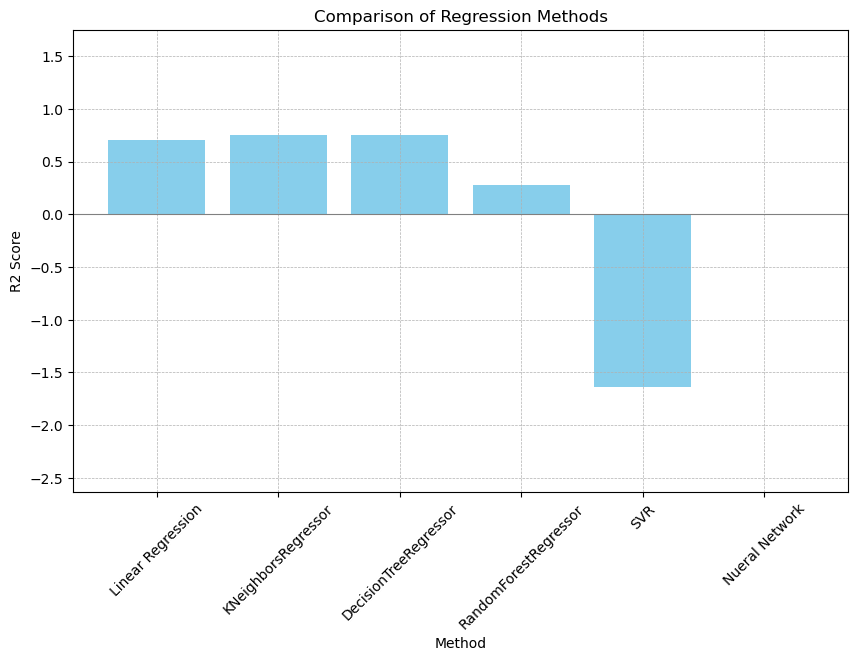

In [132]:
import matplotlib.pyplot as plt

methods = df4['Method'].tolist() 
r2_scores = df4['R2 Score'].tolist()

plt.figure(figsize=(10, 6))
plt.bar(methods, r2_scores, color='skyblue')
plt.xlabel('Method')
plt.ylabel('R2 Score')
plt.title('Comparison of Regression Methods')
plt.xticks(rotation=45)
plt.ylim(min(r2_scores) - 1, max(r2_scores) + 1)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.axhline(0, color='gray', linewidth=0.8)
plt.show()